In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, make_scorer, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import shap

import matplotlib.pyplot as plt

In [2]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/TUMOUR.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_ville.csv'
path_to_csv_ozgun = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.csv'
path_to_csv_ozgun_target = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.xlsx'

In [3]:
data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)
data_eval = dt.fread(path_to_csv_ozgun).to_pandas()
target_eval = pd.read_excel(path_to_csv_ozgun_target, sheet_name='Sheet2')

In [4]:
original_radiomic_train_data = data_train.filter(regex='original')
original_radiomic_eval_data = data_eval.filter(regex='original')

In [5]:
originalT1_40_train_data = original_radiomic_train_data.filter(regex='40')
originalT1_train_data = original_radiomic_train_data[original_radiomic_train_data.columns.drop(list(original_radiomic_train_data.filter(regex='40|T2')))]

In [6]:
originalT1_40_eval_data = original_radiomic_eval_data.filter(regex='40')
originalT1_eval_data = original_radiomic_eval_data[original_radiomic_eval_data.columns.drop(list(original_radiomic_eval_data.filter(regex='40|T2')))]

In [7]:
original_shape_features_train_data_T1 = originalT1_train_data.filter(regex='shape')
original_shape_features_train_data_T1_40 = originalT1_40_train_data.filter(regex='shape')
print(str(original_radiomic_train_data.shape))
print(str(originalT1_40_train_data.shape))
print(str(original_shape_features_train_data_T1_40.shape))

original_shape_features_eval_data_T1 = originalT1_eval_data.filter(regex='shape')
original_shape_features_eval_data_T1_40 = originalT1_40_eval_data.filter(regex='shape')
print(str(original_radiomic_eval_data.shape))
print(str(originalT1_40_eval_data.shape))
print(str(original_shape_features_eval_data_T1_40.shape))

(136, 321)
(136, 107)
(136, 14)
(50, 214)
(50, 107)
(50, 14)


<Axes: >

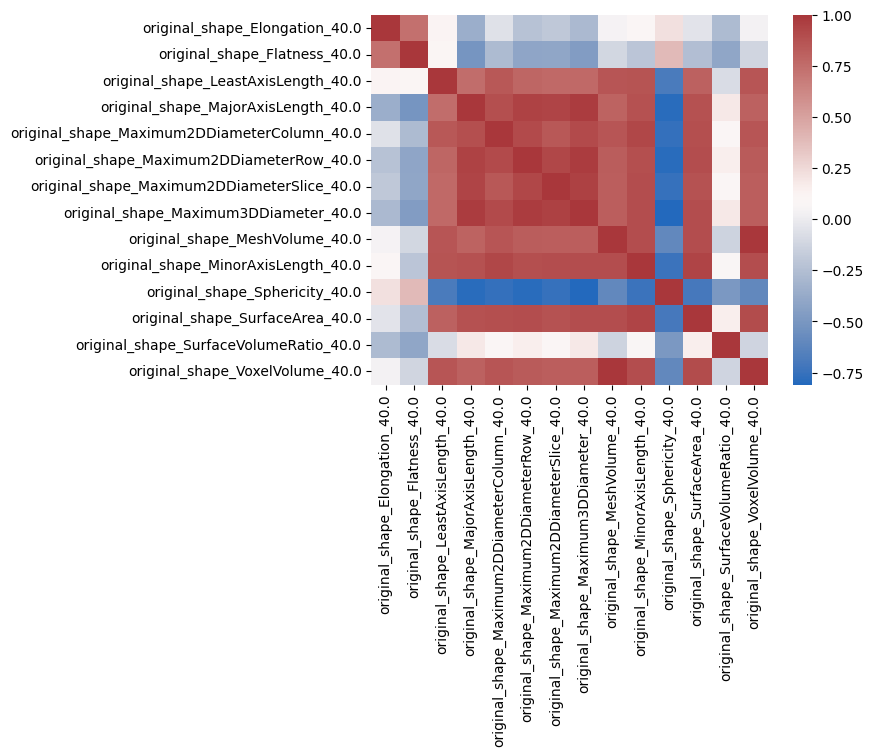

In [8]:
sns.heatmap(original_shape_features_train_data_T1_40.corr(), cmap='vlag')

In [9]:
smallest_nb_of_features_T1_40 = original_shape_features_train_data_T1_40[['original_shape_Elongation_40.0', 'original_shape_Sphericity_40.0', 'original_shape_SurfaceVolumeRatio_40.0',  'original_shape_Flatness_40.0']]
smallest_nb_of_features_T1 = original_shape_features_train_data_T1[['original_shape_Elongation', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 'original_shape_Flatness']]

smallest_nb_of_features_eval_T1_40 = original_shape_features_eval_data_T1_40[['original_shape_Elongation_40.0', 'original_shape_Sphericity_40.0', 'original_shape_SurfaceVolumeRatio_40.0', 'original_shape_Flatness_40.0']]

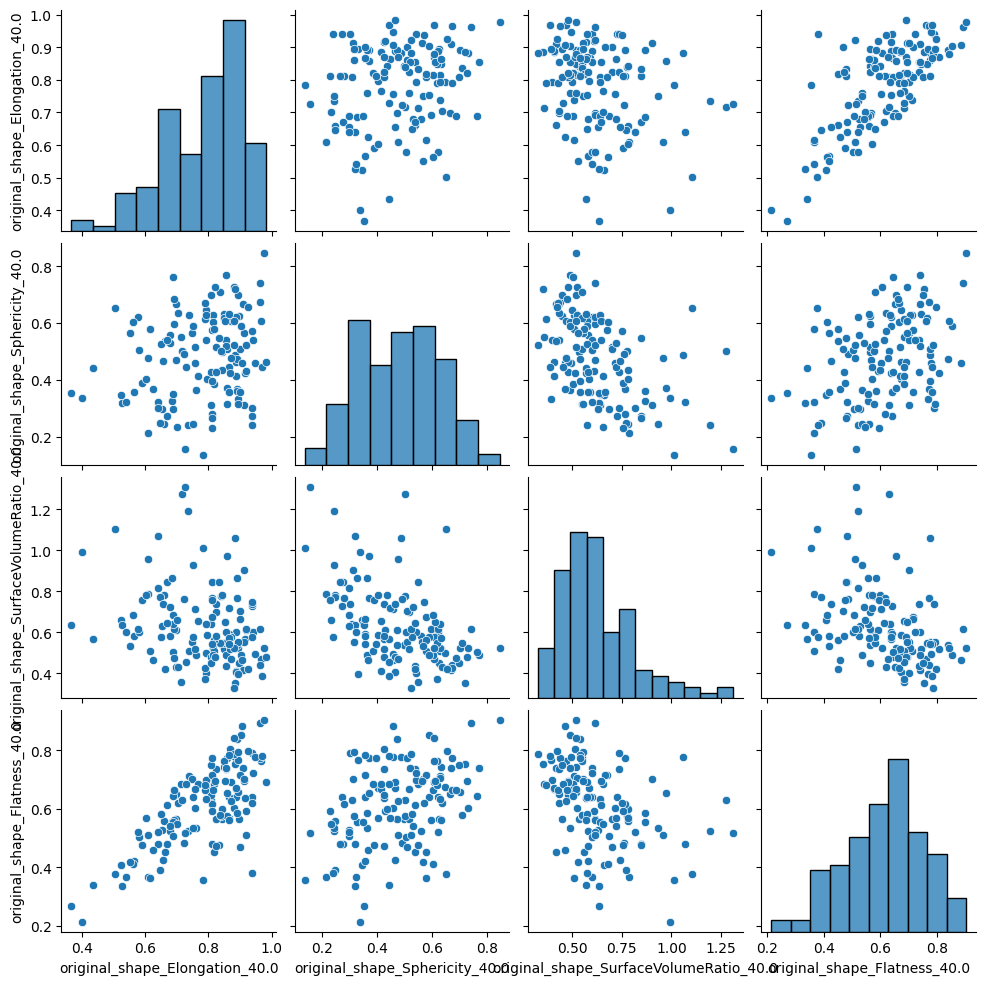

In [10]:
sns.pairplot(smallest_nb_of_features_T1_40)

In [11]:
#sns.pairplot(original_shape_features_train_data_T1_40)

In [12]:
shape_target_train = data_train[['Shape.1']]
margins_target_train = data_train[['Margins (MR)']]
shape_target_eval = target_eval[['mr_mass_shp.factor']]
margins_target_eval = target_eval[['mr_mass_mrg.factor']]

In [13]:
shape_target_train.value_counts()

Shape.1  
Irregular    104
Round         19
Oval          13
Name: count, dtype: int64

In [14]:
shape_target_eval.value_counts()

mr_mass_shp.factor
Irregular             37
Round                  7
Oval                   6
Name: count, dtype: int64

In [15]:
label_encoder = LabelEncoder()
shape_target_train['Shape.1']= label_encoder.fit_transform(shape_target_train['Shape.1']) 
shape_target_eval['mr_mass_shp.factor']= label_encoder.transform(shape_target_eval['mr_mass_shp.factor'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
shape_target_train.value_counts()

Shape.1
0          104
2           19
1           13
Name: count, dtype: int64

In [17]:
shape_target_eval.value_counts()

mr_mass_shp.factor
0                     37
2                      7
1                      6
Name: count, dtype: int64

In [18]:
shape_target_train.loc[shape_target_train['Shape.1']==2, 'Shape.1'] = 1
shape_target_eval.loc[shape_target_eval['mr_mass_shp.factor']==2, 'mr_mass_shp.factor'] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: xlabel='Shape.1'>

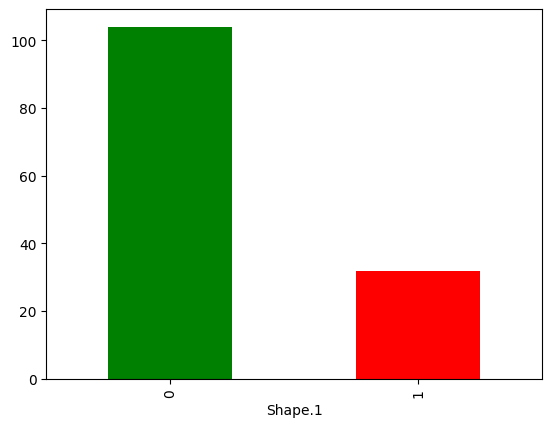

In [19]:
shape_target_train['Shape.1'].value_counts().plot.bar(color=['green', 'red'])

<Axes: xlabel='mr_mass_shp.factor'>

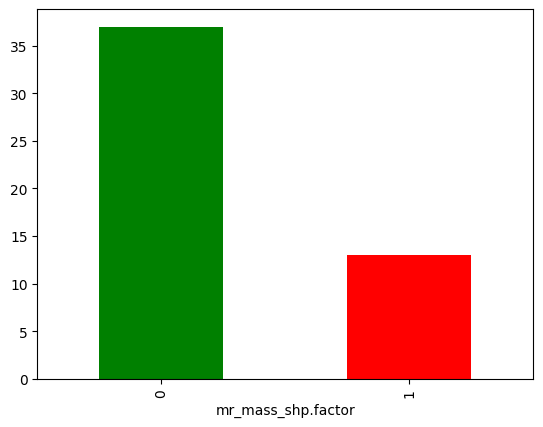

In [20]:
shape_target_eval['mr_mass_shp.factor'].value_counts().plot.bar(color=['green', 'red'])

In [21]:
scaler_T1_40 = StandardScaler()
scaled_original_radiomic_train_data_T1_40 = pd.DataFrame(scaler_T1_40.fit_transform(original_shape_features_train_data_T1_40), columns=original_shape_features_train_data_T1_40.columns)

scaler_T1 = StandardScaler()
scaled_original_radiomic_train_data_T1 = pd.DataFrame(scaler_T1.fit_transform(original_shape_features_train_data_T1), columns=original_shape_features_train_data_T1.columns)

In [22]:
smallest_nb_of_features_scaler_T1_40 = StandardScaler()
scaled_smallest_nb_of_features_T1_40 = pd.DataFrame(smallest_nb_of_features_scaler_T1_40.fit_transform(smallest_nb_of_features_T1_40), columns=smallest_nb_of_features_T1_40.columns)

smallest_nb_of_features_scaler_T1 = StandardScaler()
scaled_smallest_nb_of_features_T1 = pd.DataFrame(smallest_nb_of_features_scaler_T1.fit_transform(smallest_nb_of_features_T1), columns=smallest_nb_of_features_T1.columns)

In [23]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [24]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, X):

    coef_dict = {}

    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef

    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [25]:
# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):

    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')

    return color_vals

 
# Visualize coefficients
def visualize_coefs(coef_dict):

    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)

    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')

    plt.show()

In [26]:
rs = 123

# Grid search hyperparameters for a logistic regression model

def grid_search_lr(X_train, y_train, kfolds):
    params_grid = {
            'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'penalty': ["l1", "l2"],
            
            'C': np.arange(0.1, 3, 0.1)
                    }

    lr_model = LogisticRegression(random_state=rs, max_iter=1000, solver="liblinear")
    grid_search = GridSearchCV(estimator = lr_model,
                               param_grid = params_grid,
                               scoring='f1',
                               
                               cv = kfolds.split(X_train, y_train), 
                               verbose = 1)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

 

# Grid search hyperparameters for a random forest model

def grid_search_rf(X_train, y_train, kfolds):

    params_grid = {
            'max_depth': [2, 5, 10, 15, 20],
            'n_estimators': [5, 50, 100, 150, 200],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features' : ['sqrt', 'log2', None],
            'class_weight': [None, {0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}]

    }

    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                               param_grid = params_grid,
                               scoring='f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

def grid_search_xgb(X_train, y_train, kfolds, sample_weight):

    params_grid = {
        'max_depth': range (2, 10, 1),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }

    boost_model = XGBClassifier(objective= 'binary:logistic',
                                nthread=4, 
                                scale_pos_weight = sample_weight,
                                random_state=rs)
    grid_search = GridSearchCV(estimator=boost_model,
                               param_grid=params_grid,
                               scoring = 'f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)
    
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search


    
def return_kfold_score(model, to_fit, target, metric, kfolds, name=None):
    score = cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).mean()
    if name is None:
        print(metric + ' ' + str(score))
    else:
        print(name + ' ' + str(score))
    return score

In [27]:
best_params_logreg_T1_40, grid_search_logreg_T1_40 = grid_search_lr(scaled_original_radiomic_train_data_T1_40, shape_target_train.values.ravel(), skf)
best_params_logreg_T1, grid_search_logreg_T1 = grid_search_lr(scaled_original_radiomic_train_data_T1, shape_target_train.values.ravel(), skf)

best_params_logreg_smallest_nb_of_features_T1_40, grid_search_logreg_smallest_nb_of_features_T1_40 = grid_search_lr(scaled_smallest_nb_of_features_T1_40, shape_target_train.values.ravel(), skf)
best_params_logreg_smallest_nb_of_features_T1, grid_search_logreg_smallest_nb_of_features_T1 = grid_search_lr(scaled_smallest_nb_of_features_T1, shape_target_train.values.ravel(), skf)


Fitting 5 folds for each of 348 candidates, totalling 1740 fits
Fitting 5 folds for each of 348 candidates, totalling 1740 fits
Fitting 5 folds for each of 348 candidates, totalling 1740 fits
Fitting 5 folds for each of 348 candidates, totalling 1740 fits


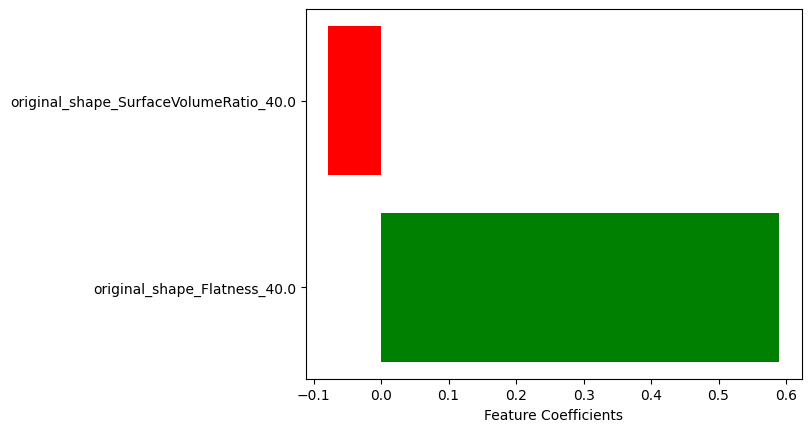

In [28]:
coef_dict = get_feature_coefs(grid_search_logreg_T1_40.best_estimator_, scaled_original_radiomic_train_data_T1_40)
visualize_coefs(coef_dict)

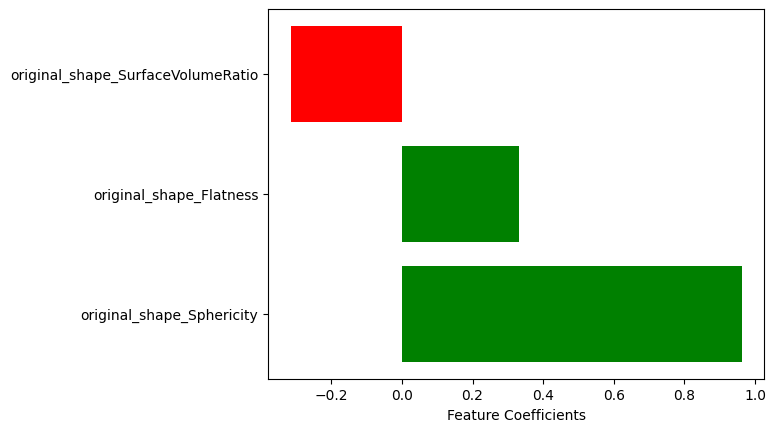

In [29]:
coef_dict = get_feature_coefs(grid_search_logreg_T1.best_estimator_, scaled_original_radiomic_train_data_T1)
visualize_coefs(coef_dict)

In [30]:
background_values_T1_40 = shap.maskers.Independent(scaled_original_radiomic_train_data_T1_40, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(grid_search_logreg_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(scaled_original_radiomic_train_data_T1_40)

In [31]:
background_values_T1 = shap.maskers.Independent(scaled_original_radiomic_train_data_T1, max_samples=100)
# compute SHAP values
explainer_T1 = shap.Explainer(grid_search_logreg_T1.predict, background_values_T1)
shap_values_T1 = explainer_T1(scaled_original_radiomic_train_data_T1)

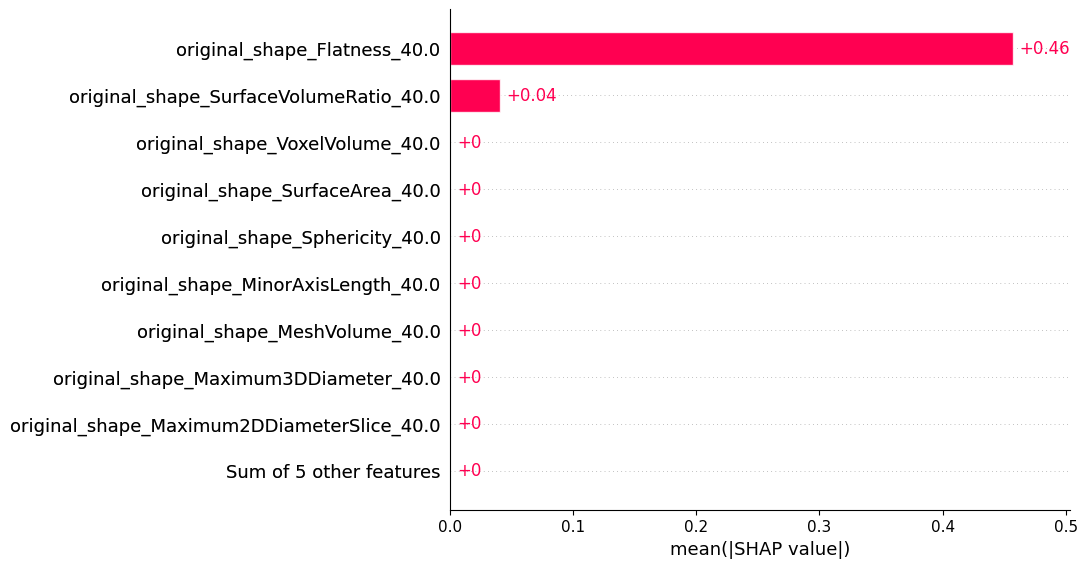

In [32]:
shap.plots.bar(shap_values_T1_40)

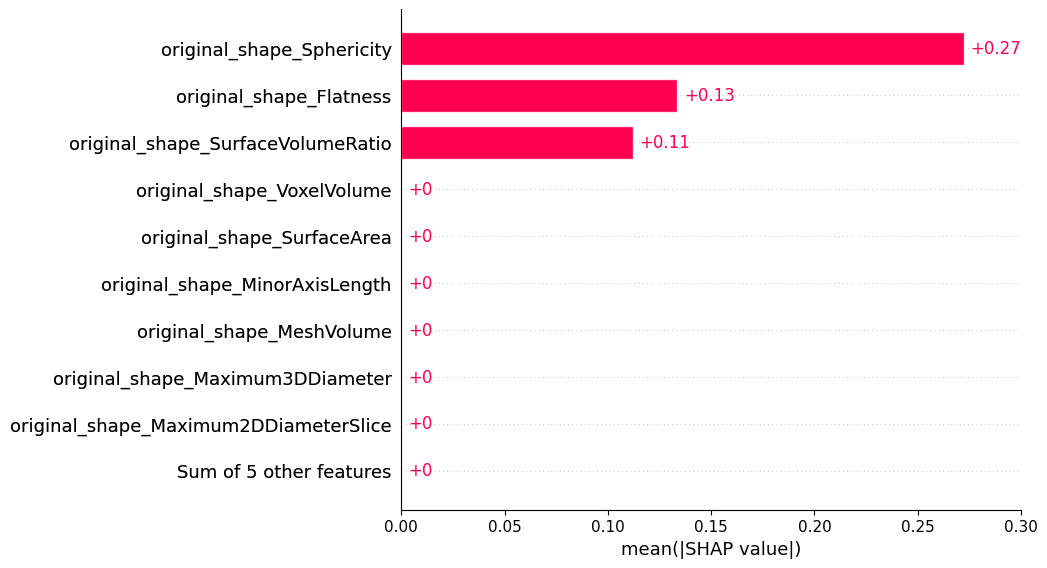

In [33]:
shap.plots.bar(shap_values_T1)

In [34]:
best_params_rf_T1_40, grid_search_randomforest_T1_40 = grid_search_rf(original_shape_features_train_data_T1_40, shape_target_train.values.ravel(), skf)
best_params_rf_T1, grid_search_randomforest_T1 = grid_search_rf(original_shape_features_train_data_T1, shape_target_train.values.ravel(), skf)

best_params_rf_smallest_nb_of_features_T1_40, grid_search_randomforest_smallest_nb_of_features_T1_40 = grid_search_rf(smallest_nb_of_features_T1_40, shape_target_train.values.ravel(), skf)
best_params_rf_smallest_nb_of_features_T1, grid_search_randomforest_smallest_nb_of_features_T1 = grid_search_rf(smallest_nb_of_features_T1, shape_target_train.values.ravel(), skf)

Fitting 5 folds for each of 2625 candidates, totalling 13125 fits


Fitting 5 folds for each of 2625 candidates, totalling 13125 fits
Fitting 5 folds for each of 2625 candidates, totalling 13125 fits
Fitting 5 folds for each of 2625 candidates, totalling 13125 fits


In [35]:
best_params_rf_T1_40

{'class_weight': {0: 0.2, 1: 0.8},
 'max_depth': 2,
 'max_features': None,
 'min_samples_split': 15,
 'n_estimators': 150}

In [36]:
ratio = float(shape_target_train.value_counts()[0]) / shape_target_train.value_counts()[1]

In [37]:
best_params_xgb_T1_40, grid_search_xgboost_T1_40 = grid_search_xgb(original_shape_features_train_data_T1_40, shape_target_train.values.ravel(), skf, ratio)
best_params_xgb_T1, grid_search_xgboost_T1 = grid_search_xgb(original_shape_features_train_data_T1, shape_target_train.values.ravel(), skf, ratio)

best_params_xgb_smallest_nb_of_features_T1_40, grid_search_xgboost_smallest_nb_of_features_T1_40 = grid_search_xgb(smallest_nb_of_features_T1_40, shape_target_train.values.ravel(), skf, ratio)
best_params_xgb_smallest_nb_of_features_T1, grid_search_xgboost_smallest_nb_of_features_T1 = grid_search_xgb(smallest_nb_of_features_T1, shape_target_train.values.ravel(), skf, ratio)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [38]:
def compile_results(model, X, y, kfolds):
    auc = return_kfold_score(model, X, y, 'roc_auc', kfolds)
    balanced_accuracy = return_kfold_score(model, X, y, 'balanced_accuracy', kfolds)
    precision = return_kfold_score(model, X, y, 'precision', kfolds)
    recall = return_kfold_score(model, X, y, 'recall', kfolds)
    f1 = return_kfold_score(model, X, y, 'f1', kfolds)

    scoring = {
        'sensitivity': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0)
    }
    specificity = return_kfold_score(model, X, y, scoring['specificity'], kfolds, 'specificity')
    sensitivity = return_kfold_score(model, X, y, scoring['sensitivity'], kfolds, 'sensitivity')
    youden_index = sensitivity + specificity - 1
    print('youden index: ' + str(youden_index))

In [39]:
print('Logistic Regression_T1_40')
compile_results(grid_search_logreg_T1_40.best_estimator_, scaled_original_radiomic_train_data_T1_40, shape_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_40')
compile_results(grid_search_randomforest_T1_40.best_estimator_, original_shape_features_train_data_T1_40, shape_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_40')
compile_results(grid_search_xgboost_T1_40.best_estimator_, original_shape_features_train_data_T1_40, shape_target_train.values.ravel(), skf)

Logistic Regression_T1_40
roc_auc 0.736077097505669
balanced_accuracy 0.7300000000000001
precision 0.4172619047619047
recall 0.8238095238095239
f1 0.5447342995169082
specificity 0.6361904761904762
sensitivity 0.8238095238095239
youden index: 0.45999999999999996

Random Forest_T1_40
roc_auc 0.725907029478458
balanced_accuracy 0.7154761904761905
precision 0.44706349206349205
recall 0.7285714285714285
f1 0.5416050616050616
specificity 0.7023809523809523
sensitivity 0.7285714285714285
youden index: 0.43095238095238075

XG Boost_T1_40
roc_auc 0.724047619047619
balanced_accuracy 0.7180952380952381
precision 0.4340048840048841
recall 0.7333333333333333
f1 0.5364745196324143
specificity 0.7028571428571428
sensitivity 0.7333333333333333
youden index: 0.43619047619047624


In [40]:
print('Logistic Regression_T1_DCE')
compile_results(grid_search_logreg_T1.best_estimator_, scaled_original_radiomic_train_data_T1, shape_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_DCE')
compile_results(grid_search_randomforest_T1.best_estimator_, original_shape_features_train_data_T1, shape_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_DCE')
compile_results(grid_search_xgboost_T1.best_estimator_, original_shape_features_train_data_T1, shape_target_train.values.ravel(), skf)

Logistic Regression_T1_DCE
roc_auc 0.7586621315192744
balanced_accuracy 0.7107142857142857
precision 0.45714285714285713
recall 0.719047619047619
f1 0.5473546611627107
specificity 0.7023809523809523
sensitivity 0.719047619047619
youden index: 0.42142857142857126

Random Forest_T1_DCE
roc_auc 0.755124716553288
balanced_accuracy 0.7040476190476189
precision 0.41154061624649857
recall 0.7619047619047619
f1 0.5171297809741746
specificity 0.6461904761904762
sensitivity 0.7619047619047619
youden index: 0.40809523809523807

XG Boost_T1_DCE
roc_auc 0.7326984126984127
balanced_accuracy 0.6864285714285714
precision 0.385
recall 0.7571428571428571
f1 0.5008289955658377
specificity 0.6157142857142858
sensitivity 0.7571428571428571
youden index: 0.3728571428571428


In [41]:
print('Logistic Regression_T1_40_small')
compile_results(grid_search_logreg_smallest_nb_of_features_T1_40.best_estimator_, scaled_smallest_nb_of_features_T1_40, shape_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_40_small')
compile_results(grid_search_randomforest_smallest_nb_of_features_T1_40.best_estimator_, scaled_smallest_nb_of_features_T1_40, shape_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_40_small')
compile_results(grid_search_xgboost_smallest_nb_of_features_T1_40.best_estimator_, scaled_smallest_nb_of_features_T1_40, shape_target_train.values.ravel(), skf)

Logistic Regression_T1_40_small
roc_auc 0.736077097505669
balanced_accuracy 0.7300000000000001
precision 0.4172619047619047
recall 0.8238095238095239
f1 0.5447342995169082
specificity 0.6361904761904762
sensitivity 0.8238095238095239
youden index: 0.45999999999999996

Random Forest_T1_40_small
roc_auc 0.7091609977324262
balanced_accuracy 0.7416666666666666
precision 0.42282717282717286
recall 0.8285714285714286
f1 0.5518212643909238
specificity 0.6547619047619048
sensitivity 0.8285714285714286
youden index: 0.4833333333333334

XG Boost_T1_40_small
roc_auc 0.7253174603174604
balanced_accuracy 0.7345238095238096
precision 0.4269230769230769
recall 0.7952380952380953
f1 0.5474242424242424
specificity 0.6738095238095239
sensitivity 0.7952380952380953
youden index: 0.46904761904761916


In [42]:
print('Logistic Regression_T1_small')
compile_results(grid_search_logreg_smallest_nb_of_features_T1.best_estimator_, scaled_smallest_nb_of_features_T1, shape_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_small')
compile_results(grid_search_randomforest_smallest_nb_of_features_T1.best_estimator_, scaled_smallest_nb_of_features_T1, shape_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_small')
compile_results(grid_search_xgboost_smallest_nb_of_features_T1.best_estimator_, scaled_smallest_nb_of_features_T1, shape_target_train.values.ravel(), skf)

Logistic Regression_T1_small
roc_auc 0.7533560090702949
balanced_accuracy 0.7273809523809524
precision 0.45320512820512826
recall 0.7523809523809524
f1 0.5610889970023096
specificity 0.7023809523809523
sensitivity 0.7523809523809524
youden index: 0.4547619047619047

Random Forest_T1_small
roc_auc 0.7148979591836735
balanced_accuracy 0.6747619047619048
precision 0.38916666666666666
recall 0.6952380952380952
f1 0.49423726428370396
specificity 0.6542857142857142
sensitivity 0.6952380952380952
youden index: 0.34952380952380935

XG Boost_T1_small
roc_auc 0.7270068027210884
balanced_accuracy 0.6769047619047619
precision 0.3885347401136875
recall 0.7285714285714284
f1 0.4982222222222223
specificity 0.6252380952380953
sensitivity 0.7285714285714284
youden index: 0.3538095238095238


In [43]:
def compute_pred(model, X_test):
    return model.predict(X_test)

LogisticRegression(C=0.30000000000000004, class_weight={0: 0.3, 1: 0.7},
                   max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')
sensitivity: 0.7692307692307693
specificity: 0.5405405405405406
youden_index: 0.30977130977130996
balanced_accuracy: 0.654885654885655
roc_auc: 0.654885654885655
precision: 0.37037037037037035
recall: 0.7692307692307693
              precision    recall  f1-score   support

           0       0.87      0.54      0.67        37
           1       0.37      0.77      0.50        13

    accuracy                           0.60        50
   macro avg       0.62      0.65      0.58        50
weighted avg       0.74      0.60      0.62        50

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=2,
                       max_features=None, min_samples_split=15,
                       n_estimators=150, random_state=123)
sensitivity: 0.5384615384615384
specificity: 0.7297297297297297
youden_index: 0.26819

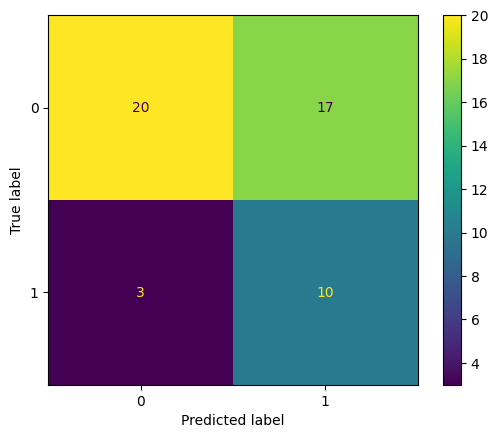

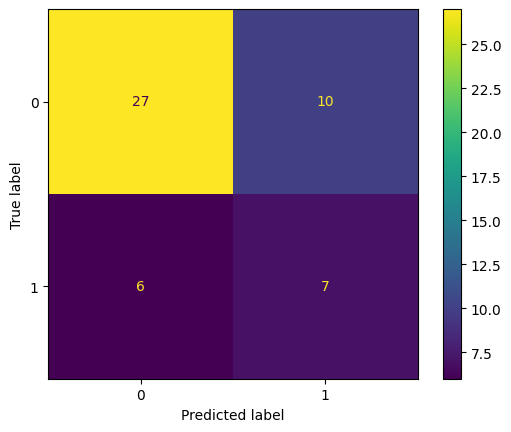

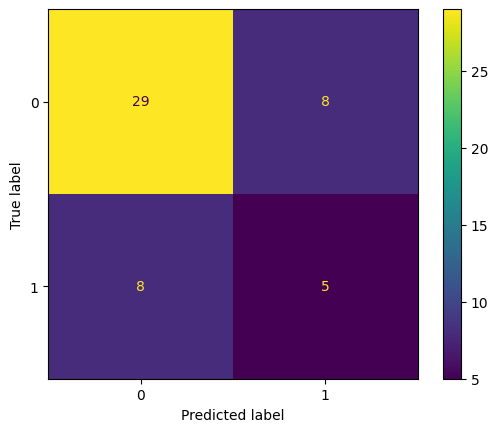

In [44]:
for model in [grid_search_logreg_T1_40.best_estimator_, grid_search_randomforest_T1_40.best_estimator_, grid_search_xgboost_T1_40.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }
    if model == grid_search_logreg_T1_40.best_estimator_:
        scaled_eval_features = pd.DataFrame(scaler_T1_40.transform(original_shape_features_eval_data_T1_40), columns=original_shape_features_eval_data_T1_40.columns)
        y_pred = compute_pred(model, scaled_eval_features)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, scaled_eval_features, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, scaled_eval_features, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, scaled_eval_features, shape_target_eval)+ scoring['sensitivity'](model, scaled_eval_features, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, scaled_eval_features, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, scaled_eval_features, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, scaled_eval_features, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, scaled_eval_features, shape_target_eval)))
        
    else:
        y_pred = compute_pred(model, original_shape_features_eval_data_T1_40)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, original_shape_features_eval_data_T1_40, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, original_shape_features_eval_data_T1_40, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, original_shape_features_eval_data_T1_40, shape_target_eval)+ scoring['sensitivity'](model, original_shape_features_eval_data_T1_40, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, original_shape_features_eval_data_T1_40, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, original_shape_features_eval_data_T1_40, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, original_shape_features_eval_data_T1_40, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, original_shape_features_eval_data_T1_40, shape_target_eval)))

    print(classification_report(shape_target_eval.values.ravel(), y_pred))
    cm = confusion_matrix(shape_target_eval.values.ravel(), y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()
    

LogisticRegression(C=0.30000000000000004, class_weight={0: 0.3, 1: 0.7},
                   max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')
sensitivity: 0.7692307692307693
specificity: 0.5405405405405406
youden_index: 0.30977130977130996
balanced_accuracy: 0.654885654885655
roc_auc: 0.654885654885655
precision: 0.37037037037037035
recall: 0.7692307692307693
              precision    recall  f1-score   support

           0       0.87      0.54      0.67        37
           1       0.37      0.77      0.50        13

    accuracy                           0.60        50
   macro avg       0.62      0.65      0.58        50
weighted avg       0.74      0.60      0.62        50

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=2,
                       max_features=None, min_samples_split=15, n_estimators=50,
                       random_state=123)
sensitivity: 0.6153846153846154
specificity: 0.7567567567567568
youden_index: 0.372141

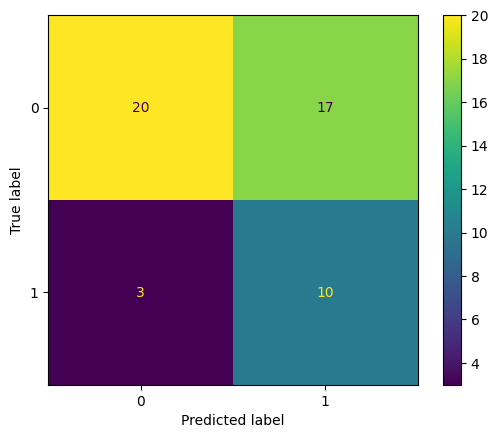

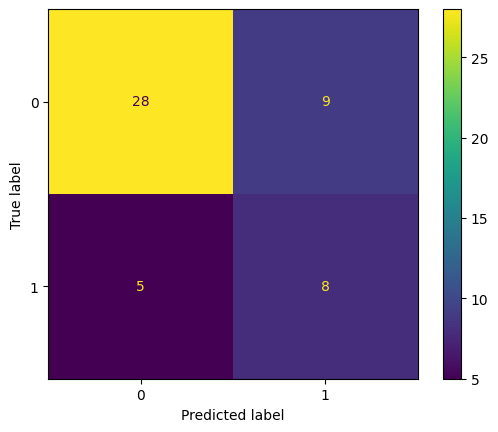

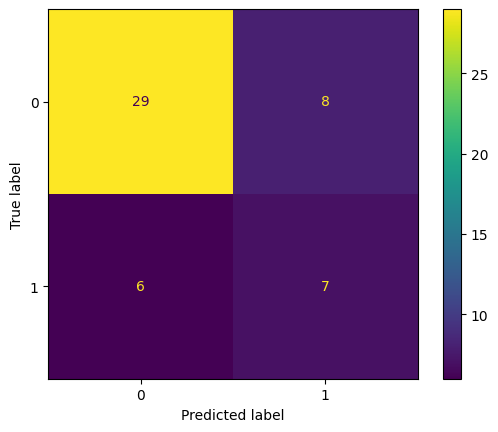

In [45]:
for model in [grid_search_logreg_smallest_nb_of_features_T1_40.best_estimator_, grid_search_randomforest_smallest_nb_of_features_T1_40.best_estimator_, grid_search_xgboost_smallest_nb_of_features_T1_40.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }
    if model == grid_search_logreg_smallest_nb_of_features_T1_40.best_estimator_:
        scaled_eval_features = pd.DataFrame(smallest_nb_of_features_scaler_T1_40.transform(smallest_nb_of_features_eval_T1_40), columns=smallest_nb_of_features_eval_T1_40.columns)
        y_pred = compute_pred(model, scaled_eval_features)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, scaled_eval_features, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, scaled_eval_features, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, scaled_eval_features, shape_target_eval)+ scoring['sensitivity'](model, scaled_eval_features, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, scaled_eval_features, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, scaled_eval_features, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, scaled_eval_features, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, scaled_eval_features, shape_target_eval)))
        
    else:
        y_pred = compute_pred(model, smallest_nb_of_features_eval_T1_40)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, smallest_nb_of_features_eval_T1_40, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, smallest_nb_of_features_eval_T1_40, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, smallest_nb_of_features_eval_T1_40, shape_target_eval)+ scoring['sensitivity'](model, smallest_nb_of_features_eval_T1_40, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, smallest_nb_of_features_eval_T1_40, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, smallest_nb_of_features_eval_T1_40, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, smallest_nb_of_features_eval_T1_40, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, smallest_nb_of_features_eval_T1_40, shape_target_eval)))

    print(classification_report(shape_target_eval.values.ravel(), y_pred))
    cm = confusion_matrix(shape_target_eval.values.ravel(), y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()

In [46]:
volume_bias_40 = pd.concat((scaled_original_radiomic_train_data_T1_40[['original_shape_MeshVolume_40.0']], shape_target_train), axis=1)
volume_bias = pd.concat((scaled_original_radiomic_train_data_T1[['original_shape_MeshVolume']], shape_target_train), axis=1)

<Axes: xlabel='original_shape_MeshVolume_40.0', ylabel='Shape.1'>

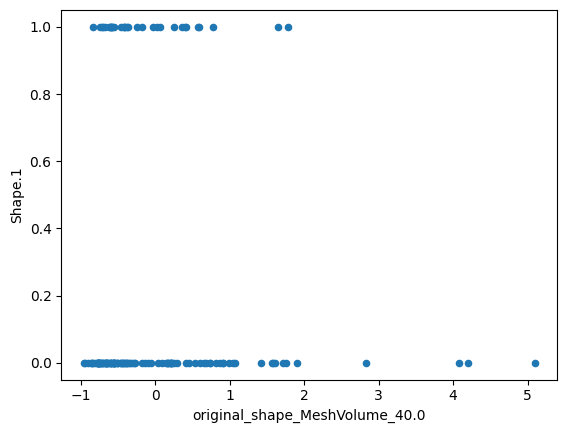

In [47]:
volume_bias_40.plot.scatter('original_shape_MeshVolume_40.0', 'Shape.1')

In [ ]:
volume_bias.plot.scatter('original_shape_MeshVolume', 'Shape.1')

In [ ]:
volume_bias_40.boxplot('original_shape_MeshVolume_40.0', 'Shape.1')

In [ ]:
volume_bias.boxplot('original_shape_MeshVolume', 'Shape.1')

In [ ]:
volume_bias_40.plot.hist(column= ['original_shape_MeshVolume_40.0'], by='Shape.1', bins=10, sharex=True)

In [ ]:
volume_bias.plot.hist(column= ['original_shape_MeshVolume'], by='Shape.1', bins=10, sharex=True)

In [ ]:
lr_mesh_volume_40 = LogisticRegression(C=0.6, class_weight={0: 0.4, 1: 0.6}, max_iter=1000, random_state=123, solver='liblinear', penalty='l2')

In [ ]:
lr_mesh_volume_40.fit(volume_bias_40[['original_shape_MeshVolume_40.0']], volume_bias_40[['Shape.1']])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_logistic_regression_line(model, X, y, xlabel, ylabel, title):
    # Scatter plot
    plt.scatter(X, y, color='blue', label='Data Points')

    # Logistic regression line
    X_test = np.linspace(X.min(), X.max(), 300)
    y_prob = model.predict_proba(X_test.reshape(-1, 1))[:, 1]
    y_pred = model.predict(X)    
    print('roc_auc: ' + str(roc_auc_score(y, y_pred)))
    plt.plot(X_test, y_prob, color='red', linewidth=2, label='Logistic Regression Line')

    # Labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Legend
    plt.legend()

    # Show the plot
    plt.show()

# Assuming lr_mesh_volume is your fitted logistic regression model
plot_logistic_regression_line(lr_mesh_volume_40, volume_bias_40[['original_shape_MeshVolume_40.0']], volume_bias_40['Shape.1'],
                               xlabel='original_shape_MeshVolume_40.0', ylabel='Shape.1',
                               title='Logistic Regression Line Over Scatter Plot')

In [ ]:
lr_mesh_volume = LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.6}, max_iter=1000, random_state=123, solver='liblinear', penalty='l2')

In [ ]:
lr_mesh_volume.fit(volume_bias[['original_shape_MeshVolume']], volume_bias[['Shape.1']])

In [ ]:
# Assuming lr_mesh_volume is your fitted logistic regression model
plot_logistic_regression_line(lr_mesh_volume, volume_bias[['original_shape_MeshVolume']], volume_bias['Shape.1'],
                               xlabel='original_shape_MeshVolume', ylabel='Shape.1',
                               title='Logistic Regression Line Over Scatter Plot')

In [ ]:
grid_search_logreg_T1.best_estimator_

In [ ]:
grid_search_logreg_T1_40.best_estimator_

In [ ]:
grid_search_logreg_T1_40.best_params_

In [ ]:
grid_search_logreg_T1.best_params_